# Working with Cloud-Optimized GeoTIFFs in Python

The cloud optimized GeoTIFF concept takes advantage of the very flexible and time-proven (Geo)TIFF image format to enable fast reading of large raster files, especially in a cloud hosted setting. The specification does several things to achieve this:
 - it uses efficient compression (deflate), in terms of balancing compression ratio and decompression speed
 - blocks are efficiently organized into tiles (e.g. 1024x1024 pixels)
 - overviews are built for several zoom levels to speed up resampling into lower resolutions

To demonstrate this we will quickly plot a thumbnail of an entire 30m resolution NIR composite image at continental scale. First, let's import some packages

In [1]:
from pathlib import Path
import rasterio 
import numpy as np
import math

import warnings
warnings.filterwarnings('ignore')

...and define an output directory.

In [2]:
ODSE_DATA_DIR = Path.home().joinpath('ODSE_workdir').joinpath('data')
raster_dir = ODSE_DATA_DIR.joinpath(f'cog_output')

print(f'ODSE data dir: {ODSE_DATA_DIR}')
print(f'Raster dir: {raster_dir}')

ODSE data dir: /home/opengeohub/ODSE_workdir/data
Raster dir: /home/opengeohub/ODSE_workdir/data/cog_output


We can get the zoom factors of a COG's overviews by calling the `overviews` method of a `DatasetReader`. By calculating the shape of a low resolution overview and reading the COG into exactly this shape we can quickly get a thumbnail of the dataset.

In [3]:
cog_url = 'https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_red_landsat.glad.ard_p50_30m_0..0cm_2020.09.13..2020.12.01_eumap_epsg3035_v1.1.tif'

with rasterio.open(cog_url) as src:
    # List of overviews from biggest to smallest
    oviews = src.overviews(1)
    print(oviews)
    oview = oviews[-1]
    
    thumbnail = src.read(1, out_shape=(1, src.height // oview, src.width // oview))
    
thumbnail.shape

[2, 4, 8, 16, 32, 64, 128, 256]


(589, 734)

Let's plot the resulting thumbnail.

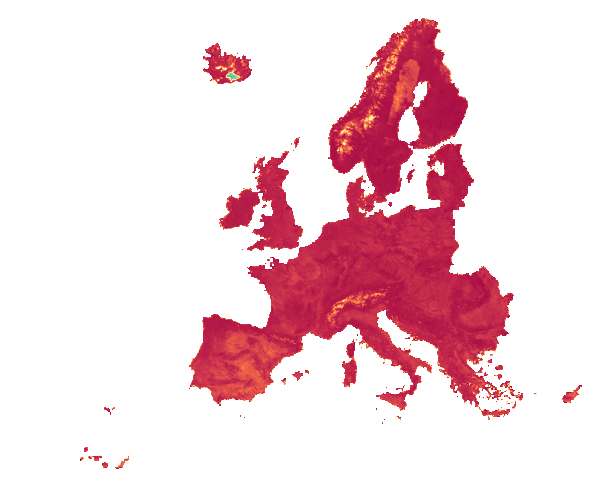

In [4]:
from eumap import plotter

plotter.plot_rasters(thumbnail, figsize=5, nodata=0)

## Reading and Writing

To demonstrate COG reads and writes, let's first make an interactive map with `ipyleaflet` that we'll use to select a bounding box around Wageningen. We can define a `DrawControl` and add it to the map controls.

In [5]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl, LayersControl

m = Map(center=(51.98, 5.65), zoom = 4, basemap= basemaps.OpenStreetMap.Mapnik)

draw_control = DrawControl()
draw_control.rectangle = {
    "shapeOptions": {
        "color": "#ff0000",
        "fillOpacity": 0,
        "opacity": 1
    }
}

m.add_control(draw_control)
m.add_control(LayersControl())

m

Map(center=[51.98, 5.65], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

We can now select the feature from `DrawControl.data` and get its bounds.

In [8]:
from shapely.geometry import shape
geometry = shape(draw_control.data[-1]['geometry'])
bounds = geometry.bounds
bounds

(5.640965, 51.96301, 5.690231, 51.982045)

`ipyleaflet.DrawControl` defines geometries in the WGS84 CRS, so we'll first transform them to ETRS89/LAEA before we can define a `Window` to read the COG.

In [9]:
from pyproj import Transformer
from rasterio.windows import Window, from_bounds

transformer = Transformer.from_crs("epsg:4326", "epsg:3035", always_xy=True)
left, bottom = transformer.transform(bounds[0], bounds[1])
right, top = transformer.transform(bounds[2], bounds[3])

window = from_bounds(left, bottom, right, top, src.transform)
print(left, bottom, right, top)
print(window)

4021589.9790108437 3214839.571676539 4025094.685535425 3216753.158557782
Window(col_off=104052.99930036147, row_off=74775.22804807394, width=116.82355081936112, height=63.78622937477485)


With the newly defined window we can quickly read directly from a large COG file stored in an S3 bucket. Let's read the window of the LANDSAT red band composite from fall 2020.

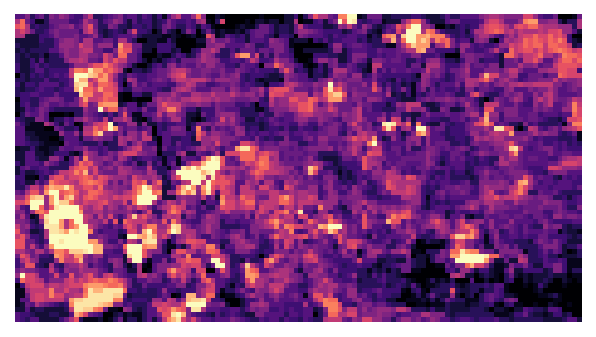

In [10]:
from eumap.raster import read_rasters, save_rasters
cog_url = 'https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_red_landsat.glad.ard_p50_30m_0..0cm_2020.09.13..2020.12.01_eumap_epsg3035_v1.1.tif'

data, _ = read_rasters(raster_files=[cog_url], spatial_win=window)
plotter.plot_rasters(data[:,:,0].astype('float32') / 255, cmaps="magma", figsize=5, perc_clip=True, vmin=0.0, vmax=1.0)

Using `eumap.raster.save_rasters` we can save the clipped data by passing the COG as the reference file along with the window definition.

In [11]:
file_name = 'wageningen_clip.tif'
save_rasters(cog_url, [ raster_dir.joinpath(file_name)], data, spatial_win=window)

[PosixPath('/home/opengeohub/ODSE_workdir/data/cog_output/wageningen_clip.tif')]

### GDAL

In [12]:
!gdalinfo /vsicurl/https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_red_landsat.glad.ard_p50_30m_0..0cm_2020.09.13..2020.12.01_eumap_epsg3035_v1.1.tif

Driver: GTiff/GeoTIFF
Files: /vsicurl/https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_red_landsat.glad.ard_p50_30m_0..0cm_2020.09.13..2020.12.01_eumap_epsg3035_v1.1.tif
Size is 188000, 151000
Coordinate System is:
PROJCRS["unknown",
    BASEGEOGCRS["unknown",
        DATUM["Unknown_based_on_GRS80_ellipsoid",
            ELLIPSOID["GRS 1980",6378137,298.257222101004,
                LENGTHUNIT["metre",1],
                ID["EPSG",7019]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]]],
    CONVERSION["Lambert Azimuthal Equal Area",
        METHOD["Lambert Azimuthal Equal Area",
            ID["EPSG",9820]],
        PARAMETER["Latitude of natural origin",52,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",10,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["False easting",4321000,
  

Switch the coordinates

In [13]:
!gdal_translate -co COMPRESS=LZW -projwin 4016208.953095281 3219443.46197307 4028890.057927307 3211285.9405564787 \
/vsicurl/https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_red_landsat.glad.ard_p50_30m_0..0cm_2020.09.13..2020.12.01_eumap_epsg3035_v1.1.tif /home/opengeohub/ODSE_workdir/data/cog_output/wageningen_clip_2.tif

Input file size is 188000, 151000
0...10...20...30...40...50...60...70...80...90...100 - done.


In [14]:
!gdalinfo /home/opengeohub/ODSE_workdir/data/cog_output/wageningen_clip.tif

Driver: GTiff/GeoTIFF
Files: /home/opengeohub/ODSE_workdir/data/cog_output/wageningen_clip.tif
Size is 116, 63
Coordinate System is:
PROJCRS["unknown",
    BASEGEOGCRS["unknown",
        DATUM["Unknown_based_on_GRS80_ellipsoid",
            ELLIPSOID["GRS 1980",6378137,298.257222101004,
                LENGTHUNIT["metre",1],
                ID["EPSG",7019]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]]],
    CONVERSION["Lambert Azimuthal Equal Area",
        METHOD["Lambert Azimuthal Equal Area",
            ID["EPSG",9820]],
        PARAMETER["Latitude of natural origin",52,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",10,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["False easting",4321000,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
        PARAMETER["Fal

In [15]:
!gdalinfo /home/opengeohub/ODSE_workdir/data/cog_output/wageningen_clip_2.tif

Driver: GTiff/GeoTIFF
Files: /home/opengeohub/ODSE_workdir/data/cog_output/wageningen_clip_2.tif
Size is 423, 272
Coordinate System is:
PROJCRS["unknown",
    BASEGEOGCRS["unknown",
        DATUM["Unknown_based_on_GRS80_ellipsoid",
            ELLIPSOID["GRS 1980",6378137,298.257222101004,
                LENGTHUNIT["metre",1],
                ID["EPSG",7019]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]]],
    CONVERSION["Lambert Azimuthal Equal Area",
        METHOD["Lambert Azimuthal Equal Area",
            ID["EPSG",9820]],
        PARAMETER["Latitude of natural origin",52,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",10,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["False easting",4321000,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
        PARAMETER["

## Time Series Access

Similarly, we can use the efficient structure of COG files to read a time series at a single point from multiple large files at once. Let's make an interactive map again, this time to pick a location by drawing a point marker

In [16]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl, LayersControl

m = Map(center=(51.98, 5.65), zoom = 5, basemap= basemaps.OpenStreetMap.Mapnik)

draw_control = DrawControl()
draw_control.point = {
    "shapeOptions": {
        "fillColor": "#ff0000",
        "color": "#ffffff",
        "fillOpacity": 0.6,
        "opacity": 1
    }
}

m.add_control(draw_control)
m.add_control(LayersControl())

m

Map(center=[51.98, 5.65], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

...and again select the geometry from the `DrawControl`.

In [17]:
from shapely.geometry import shape
geometry = shape(draw_control.data[-1]['geometry'])
geometry.x, geometry.y

(5.637703, 51.977428)

Once more we have to transform the geometry from WGS84 to ETRS89/LAEA.

In [18]:
from pyproj import Transformer
from rasterio.windows import Window, from_bounds

transformer = Transformer.from_crs("epsg:4326", "epsg:3035", always_xy=True)
lon_3035, lat_3035 = transformer.transform(geometry.x, geometry.y)
print(lon_3035, lat_3035)

4021462.328176745 3216454.7892411277


We can now use the point coordinates to sample the dataset with `rasterio`.

In [19]:
cog_url = 'https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_ndvi_landsat.glad.ard_p50_30m_0..0cm_2000.03.21..2000.06.24_eumap_epsg3035_v1.0.tif'
with rasterio.open(cog_url) as ds:
    pixel_val = next(ds.sample([(lon_3035, lat_3035)]))
    print(pixel_val)

[179]


To sample from a time series, let's first use the ODS naming scheme to construct a list of rasters.

In [20]:
def _eval(str_val):
    return eval("f'"+str_val+"'")

base_url = 'https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_ndvi_landsat.glad.ard_p50_30m_0..0cm_{dt}_eumap_epsg3035_v1.0.tif'

dates = [
    '{year-1}.12.02..{year}.03.20', # winter
    '{year}.03.21..{year}.06.24', # spring
    '{year}.06.25..{year}.09.12', # summer
    '{year}.09.13..{year}.12.01' # fall
]

ndvi_urls = []
for year in range(2000,2020):
    for _dt in dates:
        dt = _eval(_dt)
        url = _eval(base_url)
        ndvi_urls.append(url)

ndvi_urls[0:2]

['https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_ndvi_landsat.glad.ard_p50_30m_0..0cm_1999.12.02..2000.03.20_eumap_epsg3035_v1.0.tif',
 'https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_ndvi_landsat.glad.ard_p50_30m_0..0cm_2000.03.21..2000.06.24_eumap_epsg3035_v1.0.tif']

We will define an argument list and a worker function that takes a raster url and point coordinates as arguments

In [21]:
def read_pixel(cog_url, coordinates):
    pixel_val = None
    
    try:
        with rasterio.open(cog_url) as ds:
            pixel_val = np.stack(ds.sample(coordinates))
    except Exception as e:
        print(e, 'at coordinates', coordinates)
    return pixel_val

args = [ (cog_url, [ (lon_3035, lat_3035) ] ) for cog_url in ndvi_urls ] 
args[0:2]

[('https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_ndvi_landsat.glad.ard_p50_30m_0..0cm_1999.12.02..2000.03.20_eumap_epsg3035_v1.0.tif',
  [(4021462.328176745, 3216454.7892411277)]),
 ('https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_ndvi_landsat.glad.ard_p50_30m_0..0cm_2000.03.21..2000.06.24_eumap_epsg3035_v1.0.tif',
  [(4021462.328176745, 3216454.7892411277)])]

...and use `eumap` to run the sampling in parallel, and then construct a `DataFrame` from the results.

In [22]:
from eumap import parallel
from pathlib import Path
import pandas as pd
import numpy as np

result = []

for arg, pixel_vals in zip(args, parallel.job(read_pixel, args, n_jobs=-1)):
    
    raster_name = Path(arg[0]).name
    cordinates = arg[1]
    
    dt = str(raster_name).split('_')[6]
    start_date = dt.split('..')[0].replace('.','-')
    end_date = dt.split('..')[1].replace('.','-')
    
    for i in range(0, len(cordinates)):
        lon, lat = cordinates[i]
        result.append({
            'raster_name': raster_name,
            'start_date': start_date,
            'end_date': end_date,
            'lon': lon,
            'lat': lat, 
            'value': float(pixel_vals[i][0])
        })

result = pd.DataFrame(result)
result

,raster_name,start_date,end_date,lon,lat,value
0,lcv_ndvi_landsat.glad.ard_p50_30m_0..0cm_1999....,1999-12-02,2000-03-20,4.021462e+06,3.216455e+06,175.0
1,lcv_ndvi_landsat.glad.ard_p50_30m_0..0cm_2000....,2000-03-21,2000-06-24,4.021462e+06,3.216455e+06,179.0
2,lcv_ndvi_landsat.glad.ard_p50_30m_0..0cm_2000....,2000-06-25,2000-09-12,4.021462e+06,3.216455e+06,183.0
3,lcv_ndvi_landsat.glad.ard_p50_30m_0..0cm_2000....,2000-09-13,2000-12-01,4.021462e+06,3.216455e+06,177.0
4,lcv_ndvi_landsat.glad.ard_p50_30m_0..0cm_2000....,2000-12-02,2001-03-20,4.021462e+06,3.216455e+06,174.0
...,...,...,...,...,...,...
75,lcv_ndvi_landsat.glad.ard_p50_30m_0..0cm_2018....,2018-09-13,2018-12-01,4.021462e+06,3.216455e+06,176.0
76,lcv_ndvi_landsat.glad.ard_p50_30m_0..0cm_2018....,2018-12-02,2019-03-20,4.021462e+06,3.216455e+06,182.0
77,lcv_ndvi_landsat.glad.ard_p50_30m_0..0cm_2019....,2019-03-21,2019-06-24,4.021462e+06,3.216455e+06,189.0
78,lcv_ndvi_landsat.glad.ard_p50_30m_0..0cm_2019....,2019-06-25,2019-09-12,4.021462e+06,3.216455e+06,182.0


We can now plot the time series.

<AxesSubplot:>

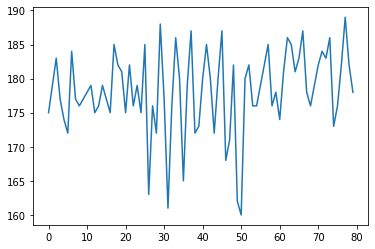

In [23]:
result['value'].plot()

The data is rescaled to byte values for efficient storage, so we have to scale it back to get the actual NDVI values.

<AxesSubplot:>

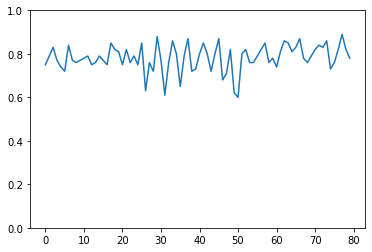

In [24]:
result['value'] = (result['value'] - 100) / 100

result['value'].plot(ylim=(0,1))